# Cleanup and Analysis of Suricata Benchmarking Results

## Experiment Definition


According to call on 2019-07-25:

- VNF: Suricata IDS
- parameters:
    - cpu_bw 0.1 - 1.0, step 0.1
    - core pinnig (1 core per container)
    - memory: 1024MB
    - rulset: empty, small, large
    - low sizes (pcaps): smallFlows, bugFlows (tcpreplay -i data -tK --loop 1000)
    - repetitions: 10
    - round time (measurement of one config): 30 seconds
- recorded metrics:
    - suricata_bytes
    - suricata_dropped
    - suricate_drops
    - suricata_packets
    
  


In [1]:
# basics
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import random
random.seed(12121)
np.random.seed(12121)
import pwlf
from sklearn import metrics as em

## Data Cleaning

In [11]:
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys
    of the mapping dict.
    It renames the columns to the values of the
    mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        #print("Renaming: {} -> {}".format(k, v))
        dff.rename(columns={k: v}, inplace=True)
    #print(dff.head())
    return dff

def cleanup(df):
    """
    Cleanup of df data.
    Dataset specific.
    """
    def _replace(df, column, str1, str2):
        if column in df:
            df[column] = df[column].str.replace(str1, str2)
            
    def _to_num(df, column):
        if column in df:
            df[column] = pd.to_numeric(df[column])
        
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 1000 --preload-pcap /pcaps/smallFlows.pcap", "small")   
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 1000 --preload-pcap /pcaps/bigFlows.pcap", "big")
    #_to_num(df, "flow_size")
    _replace(df, "ruleset", "./start.sh small_ruleset", "small")
    _replace(df, "ruleset", "./start.sh big_ruleset", "big")
    _replace(df, "ruleset", "./start.sh empty", "empty")
    #_to_num(df, "ruleset")
    


map_columns = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-suricata.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-suricata.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-suricata.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__suricata_bytes": "suricata_bytes",
    "metric__vnf0.vdu01.0__suricata_packets": "suricata_packets",
    "metric__vnf0.vdu01.0__suricata_dropped": "suricata_dropped",
    "metric__vnf0.vdu01.0__suricata_drops": "suricata_drops",
    #"metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

# initial load
df_raw = pd.read_csv("result_ec_metrics.csv")
df_raw["vnf"] = "suricata"

# cleanup data sets
dfs_raw = [df_raw]
map_list = [map_columns]
dfs = list()  # clean data frames
for (df, m) in zip(dfs_raw, map_list):
    tmp = select_and_rename(df.copy(), m)
    cleanup(tmp)
    dfs.append(tmp)
    
df = dfs[0]

In [12]:
df

,flow_size,ruleset,cpu_bw,memory,suricata_bytes,suricata_packets,suricata_dropped,suricata_drops
0,small,small,0.1,1024,24669541.0,41230.0,706334.0,0.942841
1,small,small,0.1,1024,23213914.0,38223.5,722031.0,0.946838
2,small,small,0.1,1024,24624022.5,40818.0,703056.5,0.934991
3,small,small,0.1,1024,24705459.0,41187.5,705610.5,0.941432
4,small,small,0.1,1024,24721854.0,41020.0,697294.0,0.944091
5,small,small,0.1,1024,23736026.0,39525.0,712776.5,0.943899
6,small,small,0.1,1024,23448706.0,39221.0,714420.5,0.945256
7,small,small,0.1,1024,24866051.0,41444.0,721601.0,0.944459
8,small,small,0.1,1024,24169708.0,40744.5,713794.0,0.942195
9,small,small,0.1,1024,29517909.0,48300.0,693537.0,0.935039


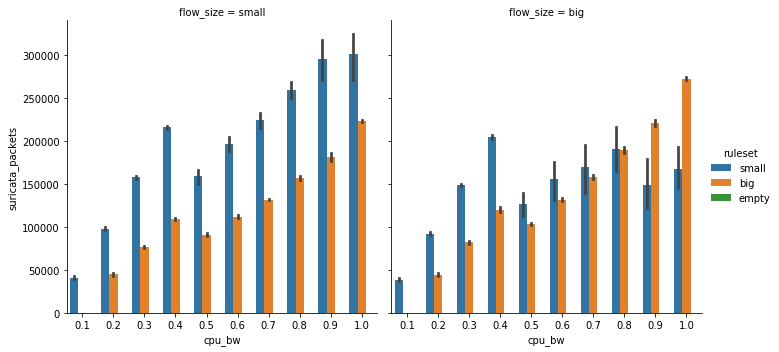

In [17]:
sns.catplot(data=df, x="cpu_bw", y="suricata_packets", hue="ruleset", col="flow_size", kind="bar")

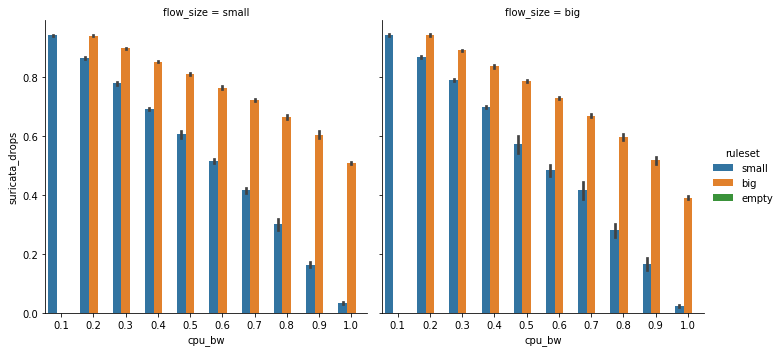

In [18]:
sns.catplot(data=df, x="cpu_bw", y="suricata_drops", hue="ruleset", col="flow_size", kind="bar")